### Content Analysis Community Pages - Inmigration Posts
### Topic Modeling 

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [5]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [6]:

#path = "Latinx2020/"
posts = pd.read_csv("community/FB_groups_States_immigration.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(11030, 39)

In [7]:

posts.shape

(11030, 39)

In [8]:
posts['URL']

0        https://www.facebook.com/groups/79341620735648...
1        https://www.facebook.com/groups/79341620735648...
2        https://www.facebook.com/groups/79341620735648...
3        https://www.facebook.com/groups/79341620735648...
4        https://www.facebook.com/groups/79341620735648...
                               ...                        
11025    https://www.facebook.com/latinosover40newyork/...
11026    https://www.facebook.com/latinosover40newyork/...
11027    https://www.facebook.com/latinosover40newyork/...
11028    https://www.facebook.com/latinosennewyork/post...
11029    https://www.facebook.com/NorthernNevadaLatinoA...
Name: URL, Length: 11030, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [9]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [10]:
posts.columns

Index(['Unnamed: 0', 'name', 'Page or Account URL', 'List', 'State', 'state',
       'Facebook Id', 'Group Name', 'User Name', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Overperforming Score', 'MessageDescr', 'MessageOnly'],
      dtype='object')

In [11]:
posts["Created"].head(5)

0    2020-08-25 11:26:26 EDT
1    2020-08-21 16:52:17 EDT
2    2020-08-20 21:22:28 EDT
3    2020-08-20 07:04:33 EDT
4    2020-08-18 17:36:00 EDT
Name: Created, dtype: object

In [12]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0       2020-08-25 11:26:26-04:00
1       2020-08-21 16:52:17-04:00
2       2020-08-20 21:22:28-04:00
3       2020-08-20 07:04:33-04:00
4       2020-08-18 17:36:00-04:00
                   ...           
11025   2020-09-16 15:38:22-04:00
11026   2020-09-16 11:38:13-04:00
11027   2020-09-15 13:44:15-04:00
11028   2020-10-29 15:34:12-04:00
11029   2020-10-29 15:23:47-04:00
Name: converted_date, Length: 11030, dtype: datetime64[ns, tzlocal()]

In [13]:
posts['converted_date']=posts['converted_date'].dt.date

In [14]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date


,converted_date,count
0,2020-08-18,121
1,2020-08-19,172
2,2020-08-20,144
3,2020-08-21,115
4,2020-08-22,61
5,2020-08-23,68
6,2020-08-24,145
7,2020-08-25,179
8,2020-08-26,202
9,2020-08-27,159


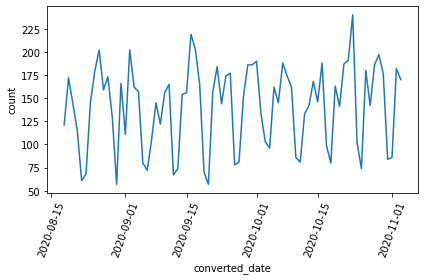

In [15]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [16]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,name,Page or Account URL,List,State,state,Facebook Id,Group Name,User Name,Likes at Posting,...,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,converted_date
0,155,Hispanos unidos en New York (H.U.N.Y),https://www.facebook.com/groups/793416207356486,Latinos+EstadosGroups,New York,New York,793416207356486,Hispanos unidos en New York (H.U.N.Y),NaN,6201.0,...,NaN,Soy un refugiado o asilado: ¿Puedo trabajar ? ...,Migración Soy un refugiado o asilado: ¿Puedo t...,NaN,NaN,0,-44.0,Soy un refugiado o asilado: ¿Puedo trabajar ? ...,Soy un refugiado o asilado: ¿Puedo trabajar ? ...,2020-08-25


In [17]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [18]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [19]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

##  Count posts in general by state

In [20]:

df_count = posts.groupby(['State']).agg({'Facebook Id':'count'}).reset_index() 

df_count.columns = ['State','Posts_Counts']
df_count.sort_values(by=['State'], ascending=True,inplace=True)
df_count.fillna(0, inplace=True)
df_count['Posts_Counts'] = df_count['Posts_Counts'].astype(int)
df_count.head(10)



,State,Posts_Counts
0,Arizona,8
1,Arkansas,3
2,California,458
3,Colorado,29
4,Connecticut,71
5,Florida,3776
6,Georgia,541
7,Illinois,127
8,Indiana,5
9,Iowa,16


In [21]:
#us_states['State'] = us_states['State']
from functools import reduce
data_frames = [df_count, us_states]
missing_states  = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
missing_states.fillna(0, inplace=True)
missing_states['Posts_Counts'] = missing_states['Posts_Counts'].astype(int)
#missing_states

## 3. Which groups are publishing the majority of the content

In [22]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
Venezolanos en Miami,624
LATINOS EN NEW YORK,448
Cubanos en miamifl,291
Venezolanos viviendo en Miami,218
Venezolanos en La Florida,216
Ecuatorianos en La Florida,194
Peruanos en DC Maryland & Virginia (DMV),193
Marketing Latinos en Atlanta ( USA ),176
Grupo de Venezolanos Activos en Georgia,175


## Tokenize words and Clean-up text

In [23]:
content = posts.copy()
content.drop_duplicates(subset= ['MessageDescr'], inplace=True)
content['MessageDescr']

0        Soy un refugiado o asilado: ¿Puedo trabajar ? ...
1        Con un contundente discurso en el que prometió...
2         Help Immigrant Workers Fighting an ICE Attack...
3         Desde el momento en que reciba su documento d...
4         Una noche de ataques contra el Pdte. Trump, l...
5        conoce a alguien que lo necesita, dígale que e...
6        Hablamos sobre quiénes califican para la Visa ...
7        Nuevo comandante general asume el mando de la ...
8         Para funcionar una corporación necesita bueno...
9         👩🏻‍💼Sobre Giselle Ayala Mateus\n\nGiselle Aya...
10       Por QueensLatino Durante el pico de la pandemi...
11        New Immigration Fees Starting October 2! \n\n...
12       Joe Biden aseveró que en "educación, sanidad, ...
13       ¿Entró indocumentado a Estados Unidos? No teng...
14       ¡Un orgullo latino! Vargas fue el estratega na...
15        En 4 Diamond Vacations queremos invitar a tod...
16       Más inmigrantes denuncian cirugías innecesaria.

In [24]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(6100,)

In [25]:
# Convert to list
data = content.cleanMessage.tolist()

In [26]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [27]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['soy', 'un', 'refugiado', 'asilado', 'puedo', 'trabajar', 'migracion', 'soy', 'un', 'refugiado', 'asilado', 'puedo', 'trabajar', 'por', 'primera', 'linea', 'agosto', 'facebook', 'twitter', 'whatsapp', 'como', 'demuestro', 'que', 'estoy', 'autorizado', 'para', 'trabajar', 'en', 'los', 'estados', 'unidos', 'como', 'refugiado', 'puede', 'trabajar', 'inmediatamente', 'despues', 'de', 'llegar', 'los', 'estados', 'unidos', 'cuando', 'se', 'soy', 'un', 'refugiado', 'asilado', 'puedo', 'trabajar', 'primera', 'linea', 'nyc'], ['con', 'un', 'contundente', 'discurso', 'en', 'el', 'que', 'prometio', 'poner', 'fin', 'un', 'largo', 'periodo', 'de', 'oscuridad', 'el', 'ex', 'vp', 'joebiden', 'acepta', 'oficialmente', 'la', 'nominacion', 'presidencial', 'democrata', 'de', 'cara', 'las', 'elecciones', 'de', 'noviembre', 'el', 'pdte', 'donald', 'trump', 'continua', 'con', 'su', 'promesa', 'de', 'construir', 'un', 'muro', 'en', 'la', 'frontera', 'con', 'mexico', 'el', 'mando', 'de', 'forthood', 'pide',

#### Creating Bigram and Trigram Models

In [28]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['soy', 'un', 'refugiado_asilado_puedo', 'trabajar', 'migracion', 'soy', 'un', 'refugiado_asilado_puedo', 'trabajar', 'por', 'primera', 'linea', 'agosto', 'facebook', 'twitter', 'whatsapp', 'como', 'demuestro', 'que', 'estoy', 'autorizado', 'para', 'trabajar', 'en', 'los', 'estados_unidos', 'como', 'refugiado', 'puede', 'trabajar', 'inmediatamente', 'despues', 'de', 'llegar', 'los', 'estados_unidos', 'cuando', 'se', 'soy', 'un', 'refugiado_asilado_puedo', 'trabajar', 'primera', 'linea', 'nyc']


## Remove Stopwords, Make Bigrams and Lemmatize

In [29]:
#import nltk
#nltk.download('stopwords')
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [30]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [31]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#!python3 -m spacy download es_core_news_sm
#!python3 -m spacy download en
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [32]:
data_lemmatized[0]

['trabajar',
 'trabajar',
 'primero',
 'linear',
 'autorizar',
 'trabajar',
 'unir',
 'refugiar',
 'trabajar',
 'inmediatamente',
 'despues',
 'llegar',
 'unir',
 'refugiado_asilado',
 'trabajar',
 'primero',
 'linear',
 'nyc']

In [33]:
print(data_words_nostops[1:2])

[['contundente', 'discurso', 'prometio', 'poner', 'fin', 'largo', 'periodo', 'oscuridad', 'vp', 'joebiden', 'acepta', 'oficialmente', 'nominacion', 'presidencial', 'democrata', 'cara', 'elecciones', 'noviembre', 'pdte', 'donald', 'trump', 'continua', 'promesa', 'construir', 'muro', 'frontera', 'mexico', 'mando', 'forthood', 'pide', 'ayuda', 'publico', 'dar', 'paradero', 'soldado', 'desaparecido', 'tx', 'sgto', 'anos', 'visto', 'ultima', 'vez', 'lunes', 'soldado', 'supuestamente', 'dejo', 'casa', 'ciudad', 'killeen', 'mil', 'personas', 'sido', 'evacuadas', 'ca', 'debido', 'incendios', 'asolan', 'varios', 'oeste', 'destruido', 'mil', 'acres', 'ennyconmas', 'contundente', 'discurso', 'prometio', 'poner', 'fin', 'largo', 'periodo', 'oscuridad', 'vp', 'joebiden', 'acepta', 'oficialmente', 'nominacion', 'presidencial', 'democrata', 'cara', 'elecciones', 'noviembre', 'pdte', 'donald', 'trump', 'continua', 'promesa', 'construir', 'muro', 'frontera', 'mexico', 'mando', 'forthood', 'pide', 'ayud

## Bag of Words

In [34]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [35]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [36]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [37]:
final_dict.most_common(1000)

[('trabajar', 884),
 ('ano', 844),
 ('hacer', 830),
 ('abogar', 754),
 ('poder', 721),
 ('casar', 706),
 ('personar', 668),
 ('legal', 652),
 ('solo', 624),
 ('hoy', 622),
 ('decir', 598),
 ('inmigrante', 594),
 ('visar', 591),
 ('trump', 552),
 ('tambien', 541),
 ('llamar', 533),
 ('nuevo', 490),
 ('familiar', 469),
 ('procesar', 468),
 ('ayudar', 459),
 ('daca', 454),
 ('unir', 444),
 ('familia', 439),
 ('mexico', 431),
 ('preguntar', 427),
 ('inmigracion', 426),
 ('querer', 407),
 ('frontero', 400),
 ('vivir', 392),
 ('dar', 376),
 ('pagar', 367),
 ('venezolano', 352),
 ('partir', 350),
 ('tiempo', 338),
 ('usar', 334),
 ('servicio', 331),
 ('contar', 326),
 ('compartir', 319),
 ('ahora', 319),
 ('conocer', 318),
 ('programar', 316),
 ('pasar', 315),
 ('ley', 312),
 ('hablar', 309),
 ('ver', 306),
 ('necesitar', 299),
 ('salir', 296),
 ('saber', 293),
 ('permiso', 291),
 ('hora', 290),
 ('tener', 289),
 ('ir', 286),
 ('tramitar', 285),
 ('esperar', 283),
 ('mensaje', 282),
 ('asilar

In [38]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [39]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
#print(bow_df)

In [40]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [41]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trabajar,3.259438
hacer,3.360100
abogar,3.393643
ano,3.415422
poder,3.420942
casar,3.447112
hoy,3.521803
legal,3.552893
personar,3.555001
solo,3.561350


In [42]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [43]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
trabajar,0.573809
linear,0.376509
primero,0.336216
nyc,0.279013
unir,0.276479
refugiado_asilado,0.264737
inmediatamente,0.227384
autorizar,0.218990
refugiar,0.200370
despues,0.161689


In [44]:
pd.set_option('display.max_colwidth',None)
#word = df.index[8]
word = r"\b(trabajar)\b"
content["lowercase"] = content['MessageOnly'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')

word_messages

/home/claudia/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


unique_messages  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

### Repeated messages

In [45]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

#results.to_csv("mostpopularNewsMedia.csv")

In [46]:
results.sort_values(by='Counts',ascending=False)

In [47]:
results.head()

,,Counts,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Total Interactions
MessageDescr,Link,,,,,,,,,,,
!!!RAZA. !! TENGAN CUIDADO. POR QUE HAY GENTE ESTAFADORA LADRONES SIN ESCRUPULOS QUE POR GANARSE UNOS CUANTOS DOLARES. \n* TE OFRECEN EMPLACAR Y TRAMITAR PLACAS O IMPORTACIONES MEXICANAS POR CORREO O ENVIOS \n*NO PERMITAS QUE TE ROBEN *\nSI LO HACES PERDERAS TU AUTOMOVIL Y TU LIBERTAD \n* 🚓 EN MEXICO PORTAR PLACAS O DOCUMENTOS FALZOS ES DELITO GRAVE Y SE PAGA CON CARCEL. \nDENUNCIA A LAS AUTORIDADES QUIEN TE OFRESCA ESOS SERVICIOS 🚓\n\n*TODAS LAS IMPORTACIONES LEGALES SE REALIZAN DENTRO DE LA ADUANA MEXICANA O A TRAVEZ DE UNA AGENCIA ADUANAL EN LA FRONTERA PERO JAMAS POR CORREO YA CON TU PEDIMENTO DE IMPORTACION. TRAMITARAS TUS PLACAS. DIRECTO EN LA SECRETARIA DE FINANZAS DE LOS DIFERENTES ESTADOS JAMAS. EN OTRA PARTE \n\nASESORIAS LEGALES Y ADUANALES GRATUITAS DESDE TIJUANA. 664 3799605 \n\nATT. AUTOBROKER’S TIJUANA Ville https://www.facebook.com/photo.php?fbid=832739714135823&set=gm.3324470137666848&type=3,https://www.facebook.com/photo.php?fbid=832739714135823&set=gm.3324470137666848&type=3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
!!!ULTIMO DIA PARA QUE ENTREN EN EL SORTEO!!!!!!🔥🔥🔥🔥🔥\n.\nCómo entrar FACIL!!! Lean los pasos👇🔥🔥🔥\n.\nSíguenos en Instagram @h-town_custom_gunsngrips\nY en nuestra página de facebook\n.\nEtiqueta 5 amigos cada 5 que etiquetes es una entrada\n.\nComparte nuestra publicación en tu muro e historia.\n.\nY tienes que ser de estados unidos mayor de 21 para poder ganarte la corredera personalizada a mano.\n.\nTIENEN ASTA LAS 12 DE LA NOCHE MAÑANA se anuncian los ganadores. Suerte y gracias a todos por su apoyo feliz noche 🔥🔥🔥🔥🍻🍻🍻💯💯💯🔥🔥🔥🔥💯🔥💯🔥🔥💯🔥💯🔥💯🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥\n\n.\n.\n #guatemala #al100 #worldwide #lujosdelnarco #harleydavidson #9mm #colt #luxury #toys#deserteagle #custom #priceless #50. #gold #handmade #luxury#ak47 #gold #luxury #migustoes #becauseican #porquelaspuedo #goldplating#1911 #38super #custom #gold #colt#caroquintero #elnumero1 #custom #customgrips #cachas #1911 #colt 💯 detail Deep engraving#browning #highpower #eltahur #happycustomer #customgrips#lujosdelnarco #harleydavidson #9mm #colt #luxury #toys#deserteagle\n #custom #priceless #50. #gold #handmade #luxury#ak47 #gold #luxury #migustoes #becauseican #porquelaspuedo #goldplating#1911 #38super #custom #gold #colt#caroquintero #elnumero1 #custom #customgrips #cachas #1911 #colt 💯 detail Deep engraving#browning #highpower #eltahur #happycustomer #customgrips H-town custom grips cachas https://www.facebook.com/hcachas/videos/3323712751011560/,https://www.facebook.com/hcachas/videos/3323712751011560/,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
"!.. EL MURO..! \n\nMario Vargas Llosa, digo : "" ver el sacrificio de cubanos, nicaragüenses, norcoreanos, solo ha servido para mostrarnos muy de cerca la verdadera cara del socialcomunismo, que no es el paraíso traído a la tierra sino la tierra convertida en un verdadero infierno"". No deberíamos tener duda que Donald Trump representa, en esta difícil coyuntura histórica, el ""muro de contención"" que evitaría se instalara en la primera potencia económica y militar del mundo, un socialismo radical. \nEs necesario educar a nuestras generaciones más jóvenes sobre la verdadera historia de millones de víctimas asesinadas a manos de los regímenes comunistas durante el siglo XX. Resulta impostergable, como afirma Donald Trump : ""redoblar nuestros esfuerzos para educar a los jóvenes en los valores inherentes a la democracia y la libertad del pensamiento y la acción"". Es la ignorancia, la ideologización de la juventud y el oscurantismo en todos los tiempos los que han producido rebaños de esclavos, pendejos y fanáticos para los que en nombre de la igualdad y la justicia social, han depauperado pueblos enteros. No olvidemos que "" los malos gobernantes son elegidos por los buenos ciudadanos que no votan"" - George J. Nathan. Es tu voto.. el que decide..! Saul https://www.facebook.com/photo.php?fbid=277766285250

In [ ]:
results.reset_index()
plt.xlim(0,150)
plt.ylim(0,150)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [ ]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

## Buiding the Topic Model

In [ ]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [ ]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

## Compute Model Perplexity and Coherence Score

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

## Visualize the topics-keywords

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

## Building LDA Mallet Model

In [ ]:
os.getcwd()

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
from gensim.models.wrappers import LdaMallet


In [ ]:
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

## Finding the optimal number of topics for LDA

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

## Finding the dominant topic in each sentence

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

## Find the most representative document for each topic

In [ ]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

In [ ]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [ ]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics